In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

import sys
sys.path.append('../models')
import ResNet as resnet
import DenseNet as densenet
import EfficientNet as efficientnet
import MobileNetV2 as mobilenet
import ViT as vit

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
##########################################
######### Configure Metric Setting ####### 
##########################################
batch_size = 1
weight_path = './weights/cifar10_resnet18_base.pt'
model = torch.load(weight_path)
model.eval()
criterion = nn.CrossEntropyLoss()
member_path = '/media/data1/hyunjun/cifar-10/train/'
nonmember_path = '/media/data1/hyunjun/cifar-10/test/'
data = 'Cifar-10'
##########################################
##########################################

In [4]:

mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) 
if data == 'STL-10':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif data == 'Cifar-10':
    mean, std = (0.491, 0.482, 0.447), (0.247, 0.243, 0.262)
elif data == 'CelebA':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

model.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BasicBlock(
      (layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
      (relu): ReLU()
    )
    (1): BasicBlock(
      (layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(6

In [5]:
nonmember_set = torchvision.datasets.ImageFolder(root=nonmember_path, transform=trans)
nonmember_loader = DataLoader(nonmember_set, batch_size=batch_size, shuffle=True, drop_last=False,)
member_set = torchvision.datasets.ImageFolder(root=member_path, transform=trans)
member_loader = DataLoader(member_set, batch_size=batch_size, shuffle=True, drop_last=False,)

classes = nonmember_set.classes

In [6]:

def random_zeroing(X, factor):
    origin = X.numpy()
    for i in range(len(origin)):
        for j in range(len(origin[i])):
            mask = np.random.choice([1.0, 0.0], origin[i][j].shape, p=[1-factor, factor])
            origin[i][j] = origin[i][j] * mask
    
    return torch.Tensor(origin)

def label_resistance_loop(dataloader):
    model.eval()
    
    perturbation = []
    
    with torch.no_grad():
        for X, y in dataloader:
            perturbation_factor = 0.0
            x = random_zeroing(X, perturbation_factor)
            initial_pred = None
            while(True):
                pred, _ = model(x.to(device))
                pred = torch.argmax(pred, dim=1)
                pred = pred.cpu().numpy()
                if initial_pred is None:
                    initial_pred = pred[0]
                elif initial_pred != pred[0]:
                    perturbation.append(perturbation_factor)
                    break
                else:
                    perturbation_factor += 0.05
                if perturbation_factor > 1.0:
                    break
                x = random_zeroing(X, perturbation_factor)
                    
    return np.array(perturbation)

In [7]:
print("#################################")
print("## Non-member Label resistance ##")
print("#################################")
non_memeber = label_resistance_loop(nonmember_loader)

print("#################################")
print("#### member Label resistance ####")
print("#################################")
memeber = label_resistance_loop(member_loader)

#################################
## Non-member Label resistance ##
#################################
#################################
#### member Label resistance ####
#################################


0.20081663326653304 0.02062834112614005
0.20290603259888929 0.017474914705082115


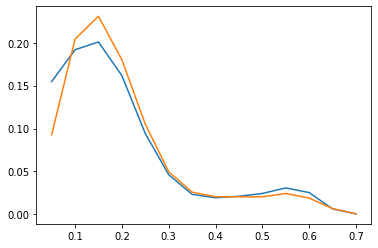

In [9]:
print(np.mean(non_memeber), np.var(non_memeber))

uniques, count = np.unique(non_memeber, return_counts=True)
count = count / np.sum(count)
plt.plot(uniques, count)
print(np.mean(memeber), np.var(memeber))

uniques, count = np.unique(memeber, return_counts=True)
count = count / np.sum(count)
plt.plot(uniques, count)
plt.show()